# Bore data extraction
---

This notebook goes through processing bore data extracted from the National Groundwater Information System (NGIS) for Australian groundwater data.

It is based on the script @ xxxx, . As a modification to this script the functions are not inserted to allow stepping through of the operations within the two functions given, i.e. <code>getBoreData()</code> and <code>getBoreDataGMW()</code>

** Important notes: **
When running through the steps in this notebook, some changes to existing objects (i.e. pandas dataframes) will be irreversible and so to go back you need to restart the kernel.

&nbsp;

First things first ... let's import the necessary modules for this exercise: [pandas](http://pandas.pydata.org/), [xlrd](https://pypi.python.org/pypi/xlrd) and [pysal](https://pypi.python.org/pypi/PySAL)



In [43]:
import numpy as np

import pandas as pd
import xlrd
# local module
from dbf2df import dbf2df  # script to import dbf as pandas.Dataframe using the pysal library

## The <code>"getBoreData()"</code> function

First thing to do is get the data from the NGIS website, we'll download Victoria data for this example:


Once downloaded, create two strings to points to the files:

In [2]:
VIC_level_data = r"C:\Workspace\part0075\MDB modelling\ngis_shp_VIC_2016\level_VIC.csv"
VIC_salinity_data = r"C:\Workspace\part0075\MDB modelling\ngis_shp_VIC_2016\salinity_VIC.csv"

If you look at the files in a text editor you will see the column headings. We can define a list of strings of headings for columns we want to load into Python using [pandas](http://pandas.pydata.org/). 

In [3]:
fields_level = ['bore_id', 'bore_date', 'obs_point_datum', 'result', 'quality_flag', 'hydroid']
fields_salinity = ['bore_id', 'bore_date', 'uom', 'result']



Now let's load the csv files into pandas:

In [4]:
dfVIC_level = pd.read_csv(VIC_level_data, sep=r',', usecols=fields_level, dtype={fields_level[0]:str, fields_level[4]:str})
dfVIC_level_raw = dfVIC_level.copy()
dfVIC_salinity = pd.read_csv(VIC_salinity_data, sep=r',', usecols=fields_salinity, dtype={fields_salinity[0]:str})

The NGIS dataset for each state as well as providing water level and salinity for bores also provides spatial data in the ESRI formatted shapefiles and dbf files. These contain details about the borehole log, construction log, and info on the hydrogeologic units as a reference. 

Let's load in this data:

In [5]:
#Construction Log File:
ConstructionLogFile = r"C:\Workspace\part0075\MDB modelling\ngis_shp_VIC_2016\ngis_shp_VIC\NGIS_ConstructionLog.dbf"
df_ConstructionLog_VIC = dbf2df(ConstructionLogFile, cols=["BoreID", "HydroCode", "TopElev", "BottomElev", "Constructi"])

#Borehole Log File:
BoreholeLogFile = r"C:\Workspace\part0075\MDB modelling\ngis_shp_VIC_2016\ngis_shp_VIC\NGIS_BoreholeLog.dbf"
df_BoreholeLog_VIC = dbf2df(BoreholeLogFile, cols=["HydroCode", "HGUNumber"])

#Hydrogeologic Unit Ref File:
HGUFile = r"C:\Workspace\part0075\MDB modelling\ngis_shp_VIC_2016\ngis_shp_VIC\NGIS_HydrogeologicUnit.dbf"
df_HydrogeologicUnit_VIC = dbf2df(HGUFile, cols=["HGUNumber", "HGCCode"])

To assist with processing the dataframes, lets also modify the "type" of data within some columns:

In [6]:
df_ConstructionLog_VIC["BoreID"] = df_ConstructionLog_VIC["BoreID"].astype(str)
df_BoreholeLog_VIC["HydroCode"] = df_BoreholeLog_VIC["HydroCode"].astype(str) 

Only use readings in mAHD ... would be nice to later convert the other ones

In [7]:
print 'Total level records: ', dfVIC_level.shape[0]

dfVIC_level = dfVIC_level[dfVIC_level['obs_point_datum'] == "RSWL (mAHD)"]
df_ConstructionLog_VIC = df_ConstructionLog_VIC[df_ConstructionLog_VIC['Constructi'] == "INLT"]

Total level records:  7005308


Get rid of unnecessary columns:

In [8]:
dfVIC_level = dfVIC_level.drop(dfVIC_level[['obs_point_datum', 'hydroid']], axis=1)

Only use data from the state observation bores:

In [9]:
dfVIC_level = dfVIC_level[dfVIC_level['quality_flag'].isin(['43', '44', '45', '47'])]

Group bores by ID and get the mean of the heads, for later look at average long term heads in the system

In [10]:
dfVIC_level_summary = dfVIC_level.groupby('bore_id').count()
dfVIC_level_summary['mean level'] = dfVIC_level.groupby('bore_id').mean()

Look at total number of unique bores that have level readings:

In [11]:
print 'Total number of unique bores with level readings: ', dfVIC_level_summary.shape[0]

Total number of unique bores with level readings:  15477


Filter out bores with less than <code>obs_num_min</code> records, in this case selection is one, so all bores are actually included

In [12]:
obs_num_min = 1
dfVIC_level_summary = dfVIC_level_summary[dfVIC_level_summary['result'] > obs_num_min]

Look at total bores after minimum records filtering:

In [13]:
print 'Total number of unique bores with at least %i readings: ' %(obs_num_min), dfVIC_level_summary.shape[0]

Total number of unique bores with at least 1 readings:  14651


Filter the data again to only what we are interested in:

In [14]:
# Get column with index
dfVIC_level_summary['HydroCode'] = dfVIC_level_summary.index

# Filter original dataset
dfVIC_level = dfVIC_level[dfVIC_level['bore_id'].isin(dfVIC_level_summary.index)]

Now we want to look at all the bores that have level information AND info on the screen so that we can place it within the correct HGU.

In [15]:
# Rename column id of 'bore_id' to bring inline with dbf files 'HydroCode'
dfVIC_level.rename(columns={'bore_id':'HydroCode'}, inplace=True) 

In [16]:
# Get bore construction info
df_bore_construction_info = pd.merge(dfVIC_level_summary, df_ConstructionLog_VIC, how='inner', on=['HydroCode'])

# For bores with multiple entries, they are ambiguous, so remove
df_bores_clear = df_bore_construction_info.groupby('HydroCode').count()

print 'Total number of bores with levels and screen info: ', df_bores_clear.shape[0] 

Total number of bores with levels and screen info:  7007


Create two dataframes now that can be passed back for further analysis but which essentially only contain bores with level data that can be referenced against the AHD and with screen info to allow placement of observation within the correct HGU.

In [17]:
# Assume bottom is the screened part and that well is not multi-screened    
df_bores_clear['mean level'] = df_bore_construction_info.groupby('HydroCode').min()['mean level']
df_bores_clear['BottomElev'] = df_bore_construction_info.groupby('HydroCode').min()['BottomElev']
df_bores_clear['TopElev'] = df_bore_construction_info.groupby('HydroCode').min()['TopElev']

# There is probably a cleaner way to do this ... but ...
# Remove unnecessary columns

df_bores_clear = df_bores_clear[['mean level', 'BottomElev', 'TopElev']]

#print 'Total number of bores with levels and screen info that is non-ambiguous: ', df_bores_clear.shape[0]

df_level_ordered = dfVIC_level.sort_values(['HydroCode', 'bore_date'])

Now let's check if some key bores made it through our filtering, e.g. if I have the following list of bores for key ecological sites that I want to have in my filtered dataset:

## The "getBoreDataGMW()" function¶

This function gets the data provided by Goulburn Murray Water which may have further and more up to date data than the NGIS. However this data set is private and cannot be shared.

Again, the first thing is to load in the data. This time, we will be loading an excel sheet, which we can then pass to pandas dataframes


In [19]:
fname = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\GW\Bore data\Shallow monitoring bores bc301115.xlsx"
fname2 = r"C:\Workspace\part0075\MDB modelling\Campaspe_data\GW\Bore data\State Observation Bores bc271115.xlsx"

with xlrd.open_workbook(fname, on_demand=True) as xls:
    sheets = xls.sheet_names()

with xlrd.open_workbook(fname2, on_demand=True) as xls:
    sheets2 = xls.sheet_names()



Next, we pass them into dataframes:


In [20]:

df_set = {}
df_set2 = {}

for sheet in sheets:
    df_set[sheet] = pd.read_excel(fname, sheetname=sheet)

for sheet in sheets2:
    df_set2[sheet] = pd.read_excel(fname2, sheetname=sheet)

for key in df_set:
    df_set[key] = pd.concat([df_set[key], df_set2[key]])


# Filter construction details to get screens:
# Index by bore ID for the filter construction drails
Screen_info = df_set['Bore Construction'].loc[df_set['Bore Construction']['Component'] == 'Screen']

# Filter lab chem sheet to get all of the salinities at bores
WaterLevel = df_set['Water Levels']
water_level_bores = pd.unique(WaterLevel['Bore ID'])


Let's cast the 'Bore ID' as strings to allow comparison with data from NGIS



In [36]:
for key in df_set.keys():
    df_set[key]['Bore ID'] = df_set[key]['Bore ID'].astype(str)

for key in df_set2.keys():
    df_set2[key]['Bore ID'] = df_set2[key]['Bore ID'].astype(str)

Let's compare the bores in these two data sets for shallow and state bores

In [39]:
shallow_unique = df_set['Water Levels']['Bore ID'].unique()
state_unique = df_set2['Water Levels']['Bore ID'].unique()

Look for overlap between the two sets with *Intersection*:

In [45]:
print("Common bores in two datasets: ", np.intersect1d(shallow_unique, state_unique, assume_unique=True).shape[0])

('Common bores in two datasets: ', 124L)


And put the two together with *Union*:

In [46]:
GMW_bores = np.union1d(shallow_unique, state_unique)

In [47]:
NGIS_bores_filtered = df_level_ordered['HydroCode'].unique()

In [51]:
print("GMW bores: %i" %GMW_bores.shape[0])
print("NGIS bores: %i" %NGIS_bores_filtered.shape[0])
print("Common bores: %i" %np.intersect1d(GMW_bores, NGIS_bores_filtered, assume_unique=True).shape[0])

GMW bores: 323
NGIS bores: 14651
Common bores: 274


Get list of bores from GMW data set that are not included in the NGIS data set

In [53]:
bores_GMW_extra = np.setdiff1d(GMW_bores, NGIS_bores_filtered)

In [56]:
GMW_extra_from_shallow = np.intersect1d(bores_GMW_extra, shallow_unique)
GMW_extra_from_state = np.intersect1d(bores_GMW_extra, state_unique)

In [58]:
GMW_extra_from_shallow

array(['109933', '110002', '110003', '110004', '110005', '110521',
       '110522', '110814', '110815', '110816', '110817', '110818',
       '110819', '110824', '110825', '115956', '138188', '138922',
       '138945', '140559', '24005', '25098', '25228', '25259', '25262',
       '25263', '25265', '25267', '25269', '25270', '25274', '25328',
       '45495', '45700', '45701', '45702', '45703', '45705', '45706',
       '45727', '45728', '45729', '45730', '45731', '45732', '45733',
       '45736', 'SP068135', 'SP068137'], dtype=object)

In [59]:
GMW_extra_from_state

array([], dtype=object)

All extra bores are from the shallow bores database ... so we now need to add them to the NGIS dataframe


In [128]:
df_bores_clear

,mean level,BottomElev,TopElev
HydroCode,,,
100017,2.294163,-112.10,-105.10
100019,57.896865,53.48,55.48
100020,2.123627,-37.02,-14.02
100021,1.750529,-31.55,-19.55
100022,1.778132,-55.74,-37.74
100023,3.296359,-23.61,0.39
100024,1.571802,-46.67,-40.67
100025,1.472059,-15.03,0.97
100267,2.642500,-7.90,-7.40


In [129]:
df_set.keys()

[u'Bore Construction',
 u'Field Chem',
 u'Water Levels',
 u'Drillers Log',
 u'Lab Chem',
 u'Site Details']

In [177]:
df_set['Site Details'].columns


Index([                        u'Bore ID',                            u'Type',
                                u'Status',                        u'Latitude',
                             u'Longitude',                 u'Location method',
                               u'Easting',                        u'Northing',
                                  u'Zone', u'Distance to nominated point (m)',
                                  u'Area',                        u'Alias ID',
                        u'Date commenced',                  u'Date completed',
                                   u'Use',   u'Date retired (decommissioned)',
                       u'Total depth (m)',          u'Drilled bore depth (m)',
                     u'Max diameter (mm)',  u'Elevation top of casing (mAHD)',
         u'Elevation ground level (mAHD)',                   u'Date surveyed',
                           u'Survey desc',                   u'Surveyor name',
               u'Survey location/comment',          

Let's remove all of the bores which have NaN top of casing or screen information.

Calculate the top and bottom elevation of screens for the shallow monitoring bores dataset by subtracting depth to top and bottom from the top of casing.

In [158]:
df_set['Site Details'] = df_set['Site Details'][np.isfinite(df_set['Site Details']['Screen top (m)'])]
df_set['Site Details'] = df_set['Site Details'][np.isfinite(df_set['Site Details']['Elevation top of casing (mAHD)'])]
df_set['Site Details']['BottomElev'] = df_set['Site Details']['Elevation top of casing (mAHD)'] - df_set['Site Details']['Screen bottom (m)']
df_set['Site Details']['TopElev'] = df_set['Site Details']['Elevation top of casing (mAHD)'] - df_set['Site Details']['Screen top (m)']
shallow_unique_with_data = df_set['Site Details']['Bore ID'].unique()

#df_set2['Site Details'] = df_set2['Site Details'][np.isfinite(df_set2['Site Details']['Screen top (m)'])]
#df_set2['Site Details'] = df_set2['Site Details'][np.isfinite(df_set2['Site Details']['Elevation top of casing (mAHD)'])]
#df_set2['Site Details']['BottomElev'] = df_set2['Site Details']['Elevation top of casing (mAHD)'] - df_set2['Site Details']['Screen bottom (m)']
#df_set2['Site Details']['TopElev'] = df_set2['Site Details']['Elevation top of casing (mAHD)'] - df_set2['Site Details']['Screen top (m)']
#state_unique_with_data = df_set['Site Details']['Bore ID'].unique()

In [161]:
GMW_extra_from_shallow_with_data = np.intersect1d(bores_GMW_extra, shallow_unique_with_data)
GMW_extra_from_shallow_with_data

array(['110002', '110003', '110004', '110005', '110521', '110522',
       '110814', '110816', '110817', '110818', '110819', '110824',
       '110825', '115956', '138188', '140559', '24005', '25328', '45495'], dtype=object)

For these bores, let's add them back into the NGIS dataframe

In [176]:
water_levels_appending = df_set['Water Levels'][df_set['Water Levels']['Bore ID'].isin(GMW_extra_from_shallow_with_data)]
water_levels_appending = water_levels_appending[np.isfinite(water_levels_appending['Reduced water level (mAHD)'])]
#print water_levels_appending[water_levels_appending['Bore ID']==110817]
water_levels_appending = water_levels_appending.groupby('Bore ID').mean()
print water_levels_appending['Reduced water level (mAHD)']
shallow_bores_appending = df_set['Site Details'][['Bore ID', 'BottomElev', 'TopElev']]

Bore ID
110002     93.74
110003     93.71
110004     93.72
110005     92.08
110521     93.81
110522     94.28
110814    107.07
110816    107.47
110819    105.84
110824    105.89
110825    107.42
138188    104.13
140559    103.89
24005      93.70
25328      93.06
Name: Reduced water level (mAHD), dtype: float64


## Viewing GW head time series for particular bores

This shows how to extract individual bore data and resample it at the monthly time step and then plot it

In [70]:
%matplotlib inline


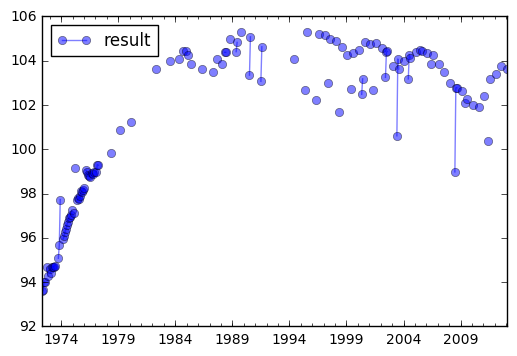

In [126]:
ts = df_level_ordered[df_level_ordered['HydroCode']=='100'].copy()
ts.set_index('bore_date', inplace=True)
ts.index = ts.index.to_datetime(dayfirst=True)
#ts.plot(y='result')
ts_2 = ts.copy()
ts = ts.resample('M').mean()
ts2 = ts_2.resample('M').count()
ts.plot(y='result', marker='o', alpha=0.5)
